Somyung Kim

In [333]:
import pandas as pd
import numpy as np
import random
from scipy.stats import ttest_ind, levene, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# random seed with 16056132
random.seed(16056132)

In [145]:
info = pd.read_csv("rmpCapstoneNum.csv", header = None)
qual = pd.read_csv("rmpCapstoneQual.csv", header = None)

In [147]:
info.columns = ["avg_rating", "avg_difficulty", "num_ratings", "pepper", "takeagain", "num_ratings_online", "male", "female"]

In [149]:
qual.columns = ["field", "university", "state"]

### Data Pre-processing

In [152]:
info.isna().sum()

avg_rating            19889
avg_difficulty        19889
num_ratings           19889
pepper                19889
takeagain             77733
num_ratings_online    19889
male                      0
female                    0
dtype: int64

In [154]:
qual.isna().sum()

field         19889
university    19889
state         19889
dtype: int64

In [156]:
info.shape

(89893, 8)

In [158]:
# remove rows where avg_rating, avg_difficulty, num_ratings are na
info.dropna(subset = ["avg_rating", "avg_difficulty", "num_ratings"], inplace = True)

In [162]:
info.shape

(70004, 8)

In [164]:
# drop rows where number of ratings are smaller than 5 (threshold) to ensure the ratingis meaningful
info = info[info["num_ratings"] > 5]

In [166]:
info.shape

(20577, 8)

In [168]:
# only retain rows present in both dataframes
common = info.index.intersection(qual.index)
info = info.loc[common].reset_index(drop = True)
qual = qual.loc[common].reset_index(drop = True)

### Gender Bias in Ratings: Statistical Analysis

In [170]:
gender_bias_data = info[(info["male"] == 1) | (info["female"] == 1)]
male_ratings = gender_bias_data.loc[gender_bias_data["male"] == 1, "avg_rating"]
female_ratings = gender_bias_data.loc[gender_bias_data["female"] == 1, "avg_rating"]

In [216]:
# determine which test to use -> levene test
gender_bias_levene_stat, gender_bias_levene_stat2 = levene(male_ratings, female_ratings)
print(gender_bias_levene_stat, gender_bias_levene_stat2)

14.457198246146726 0.00014390764503900014


As 0.00014 < 0.005, variances are not equal and we use the Welch t-test.

In [196]:
gender_bias_t_stat, gender_bias_p_value = ttest_ind(male_ratings, female_ratings, equal_var = False)
print(f"t-stat: {gender_bias_t_stat}")
print(f"p-value: {gender_bias_p_value}")

t-stat: 3.741755393148988
p-value: 0.00018340181497947106


In [210]:
if gender_bias_p_value < 0.05:
    print("Evidence of pro-male gender bias")
else:
    print("No evidence of pro-male gender bias")

Evidence of pro-male gender bias


/var/folders/mb/kl8xl_hd5339q8r8ysw76klc0000gn/T/ipykernel_91639/3358167682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1_filtered["gender"] = q1_filtered["male"].apply(lambda x: "Male" if x == 1 else "Female")
/var/folders/mb/kl8xl_hd5339q8r8ysw76klc0000gn/T/ipykernel_91639/3358167682.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="gender", y="avg_rating", data=q1_filtered, palette="pastel")


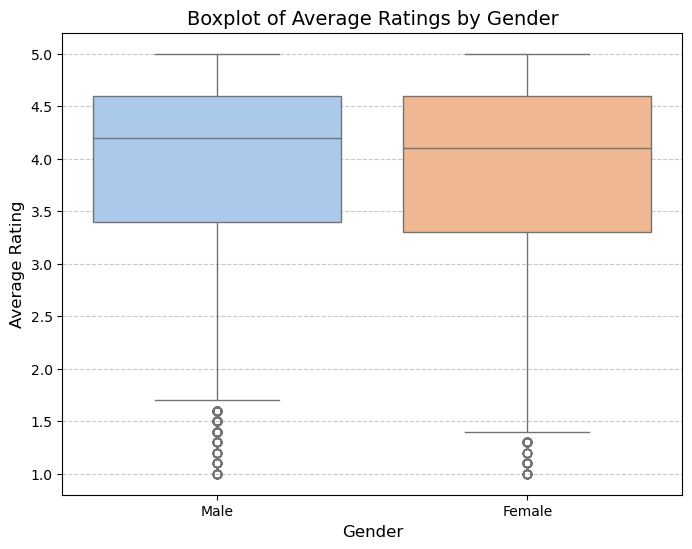

In [202]:
# Combine data for visualization
gender_bias_data["gender"] = gender_bias_data["male"].apply(lambda x: "Male" if x == 1 else "Female")

plt.figure(figsize=(8, 6))
sns.boxplot(x="gender", y="avg_rating", data=gender_bias_data, palette="pastel")
plt.title("Boxplot of Average Ratings by Gender", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("boxplot_gender_bias_ratings.png")
plt.show()

### Does Experience Impact Teaching Ratings?

In [208]:
experience_data = info.dropna(subset = ["num_ratings", "avg_rating"])
experience_corr_coeff, experience_p_value = pearsonr(experience_data["num_ratings"], experience_data["avg_rating"])
print(f"Pearson Correlation Coefficient: {experience_corr_coeff}")
print(f"p-value: {experience_p_value}")

Pearson Correlation Coefficient: 0.06109866722497483
p-value: 1.7540383001430736e-18


In [212]:
if experience_p_value < 0.005:
    print("Statistically significant relationship")
else:
    print("No statistically significant relationship")

Statistically significant relationship


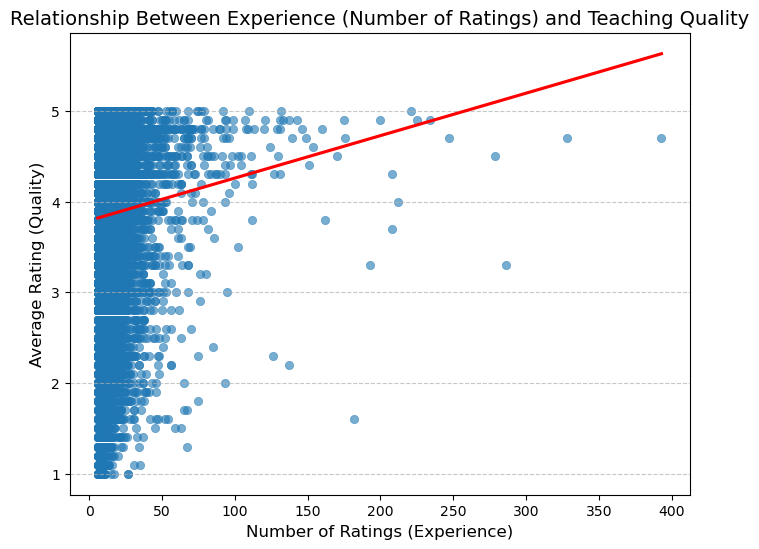

In [214]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="num_ratings", y="avg_rating", data=experience_data, alpha=0.6, edgecolor=None)
sns.regplot(x="num_ratings", y="avg_rating", data=experience_data, scatter=False, color="red", ci=None)
plt.title("Relationship Between Experience (Number of Ratings) and Teaching Quality", fontsize=14)
plt.xlabel("Number of Ratings (Experience)", fontsize=12)
plt.ylabel("Average Rating (Quality)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("experience_vs_quality.png")
plt.show()

### Impact of Course Difficulty on Teaching Ratings

In [219]:
difficulty_ratings_data = info.dropna(subset=["avg_difficulty", "avg_rating"])
difficulty_corr_coeff, difficulty_p_value = pearsonr(difficulty_ratings_data["avg_difficulty"], difficulty_ratings_data["avg_rating"])
print(f"Pearson Correlation Coefficient: {difficulty_corr_coeff}")
print(f"p-value: {difficulty_p_value}")

Pearson Correlation Coefficient: -0.6289795264111362
p-value: 0.0


In [223]:
if difficulty_p_value < 0.005:
    print("Statistically significant relationship")
else:
    print("No statistically significant relationship")

Statistically significant relationship


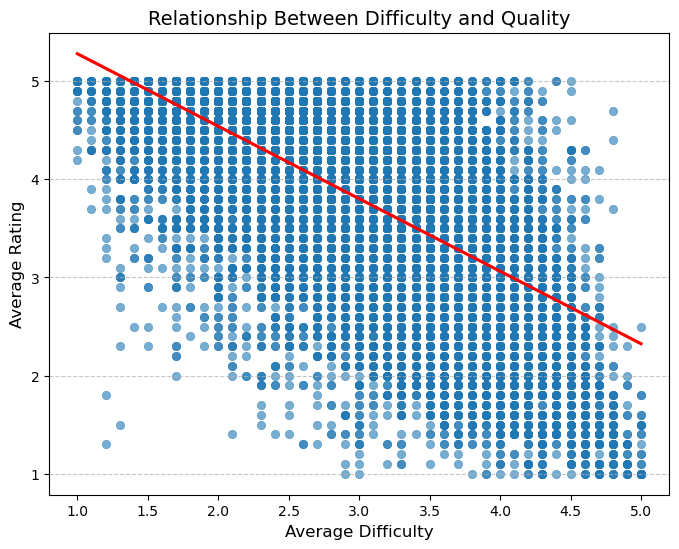

In [221]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="avg_difficulty", y="avg_rating", data=difficulty_ratings_data, alpha=0.6, edgecolor=None)
sns.regplot(x="avg_difficulty", y="avg_rating", data=difficulty_ratings_data, scatter=False, color="red", ci=None)
plt.title("Relationship Between Difficulty and Quality", fontsize=14)
plt.xlabel("Average Difficulty", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("difficulty_vs_quality.png")
plt.show()

### Are Online Professors Rated Differently Than In-Person Instructors?

In [228]:
online_vs_inperson_data = info.dropna(subset = ["num_ratings_online", "avg_rating"])
online_vs_inperson_t_stathreshold = online_vs_inperson_data["num_ratings_online"].median()
online_vs_inperson_data["online"] = online_vs_inperson_data["num_ratings_online"].apply(lambda x: "More Online" if x > online_vs_inperson_t_stathreshold else "Less Online")

In [242]:
online_vs_inperson_levene_stat, q4_lev2 = levene(online_vs_inperson_data.loc[online_vs_inperson_data["online"] == "More Online", "avg_rating"], online_vs_inperson_data.loc[online_vs_inperson_data["online"] == "Less Online", "avg_rating"])
print(online_vs_inperson_levene_stat, q4_lev2)

0.4354447574700549 0.5093366976977707


In [236]:
online_vs_inperson_t_stat, online_vs_inperson_p_value = ttest_ind(online_vs_inperson_data.loc[online_vs_inperson_data["online"] == "More Online", "avg_rating"], online_vs_inperson_data.loc[online_vs_inperson_data["online"] == "Less Online", "avg_rating"], equal_var = True)
print(f"T-stat: {online_vs_inperson_p_value}")
print(f"p-value: {online_vs_inperson_p_value}")

T-stat: 0.4733622012947165
p-value: 0.4733622012947165


In [249]:
if online_vs_inperson_p_value < 0.005:
    print("There is a statistically significant difference in average ratings based on online presence.")
else:
    print("There is no statistically significant difference in average ratings based on online presence.")

There is no statistically significant difference in average ratings based on online presence.


/var/folders/mb/kl8xl_hd5339q8r8ysw76klc0000gn/T/ipykernel_91639/1458391690.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="online", y="avg_rating", data=q4_data, palette="pastel")


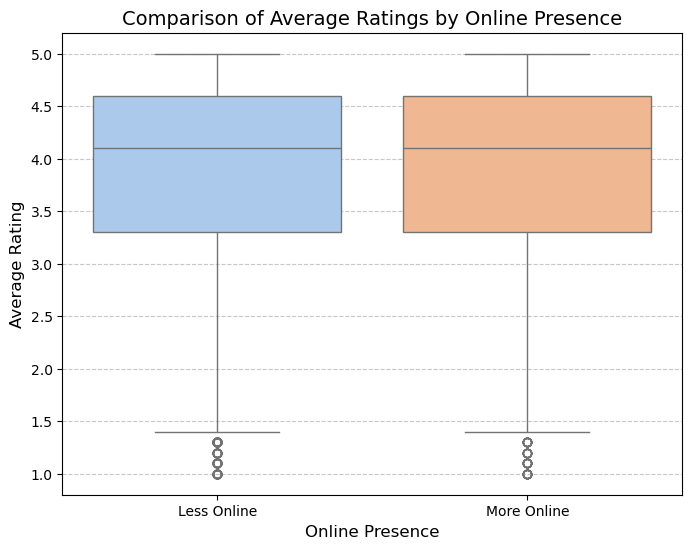

In [240]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="online", y="avg_rating", data=online_vs_inperson_data, palette="pastel")
plt.title("Comparison of Average Ratings by Online Presence", fontsize=14)
plt.xlabel("Online Presence", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("online_presence_vs_avg_rating.png")
plt.show()

### Relationship Between Average Rating and Proportion of Students Who Whould Take the Class Again

In [247]:
retake_class_data = info.dropna(subset = ["avg_rating", "takeagain"])
retake_class_corr_coeff, retake_class_p_value = pearsonr(retake_class_data["avg_rating"], retake_class_data["takeagain"])
print(f"Person Correlation Coefficient: {retake_class_corr_coeff}")
print(f"P-value: {retake_class_p_value}")

Person Correlation Coefficient: 0.8792975937151241
P-value: 0.0


In [251]:
if retake_class_p_value < 0.005:
    print("There is a statistically significant relationship between average rating and proportion of students who would take the class again.")
else:
    print("There is no statistically significant relationship between average rating and proportion of students who would take the class again.")

There is a statistically significant relationship between average rating and proportion of students who would take the class again.


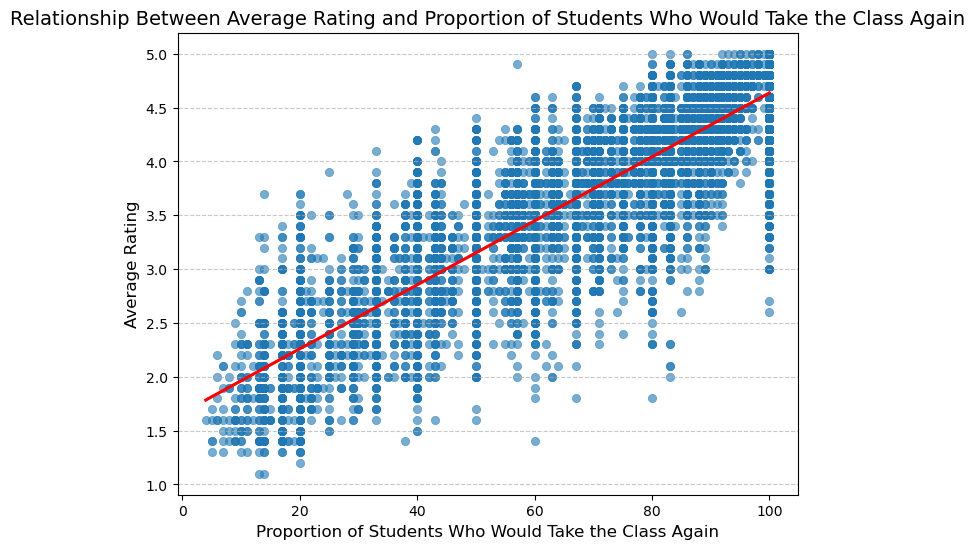

In [253]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="takeagain", y="avg_rating", data=retake_class_data, alpha=0.6, edgecolor=None)
sns.regplot(x="takeagain", y="avg_rating", data=retake_class_data, scatter=False, color="red", ci=None)
plt.title("Relationship Between Average Rating and Proportion of Students Who Would Take the Class Again", fontsize=14)
plt.xlabel("Proportion of Students Who Would Take the Class Again", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("avg_rating_vs_takeagain.png")
plt.show()

### Do 'Hot' Professors Receive Higher Ratings?

In [283]:
hotness_ratings_data = info.dropna(subset = ["pepper", "avg_rating"])
hot_prof = hotness_ratings_data.loc[hotness_ratings_data["pepper"] == 1, "avg_rating"]
not_hot_prof = hotness_ratings_data.loc[hotness_ratings_data["pepper"] == 0, "avg_rating"]

In [260]:
hotness_levene_stat1, hotness_levene_stat2 = levene(hot_prof, not_hot_prof)
print(hotness_levene_stat1, hotness_levene_stat2)

3064.698039183916 0.0


In [276]:
hotness_t_stat, hotness_p_value = ttest_ind(hot_prof, not_hot_prof, equal_var=False)
print(hotness_t_stat)
print(hotness_p_value)

83.03229213579016
0.0


In [272]:
if hotness_p_value < 0.005:
    print("There is a statistically significant difference in average ratings based on 'hotness' status.")
else:
    print("There is no statistically significant difference in average ratings based on 'hotness' status.")

There is a statistically significant difference in average ratings based on 'hotness' status.


/var/folders/mb/kl8xl_hd5339q8r8ysw76klc0000gn/T/ipykernel_91639/2989927055.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="pepper", y="avg_rating", data=q6_data, palette="pastel")


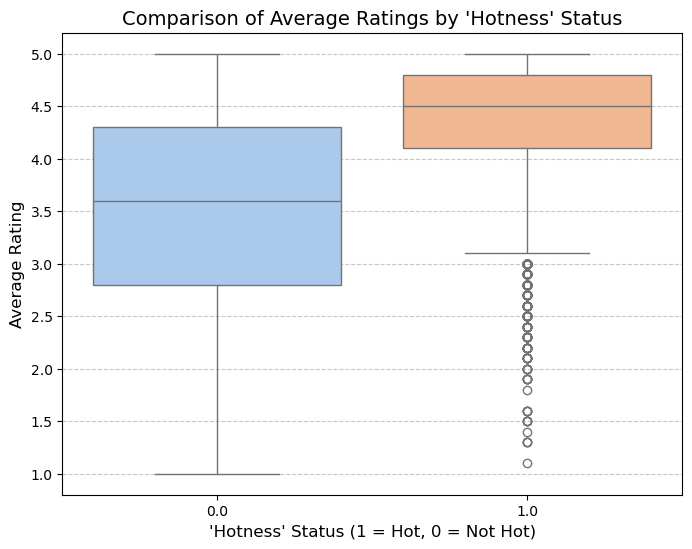

In [274]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="pepper", y="avg_rating", data=hotness_ratings_data, palette="pastel")
plt.title("Comparison of Average Ratings by 'Hotness' Status", fontsize=14)
plt.xlabel("'Hotness' Status (1 = Hot, 0 = Not Hot)", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("hotness_vs_avg_rating.png")
plt.show()

### Predicting Teaching Ratings Based on Course Difficulty

In [281]:
difficulty_model_data = info.dropna(subset = ["avg_difficulty", "avg_rating"])

In [285]:
X = difficulty_model_data[["avg_difficulty"]]
y = difficulty_model_data["avg_rating"]

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16056132)

In [289]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [291]:
y_pred = model.predict(X_test)

In [293]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [295]:
print(f"R^2: {r2}")
print(f"RMSE: {rmse}")

R^2: 0.39542896736492383
RMSE: 0.7314491182483099


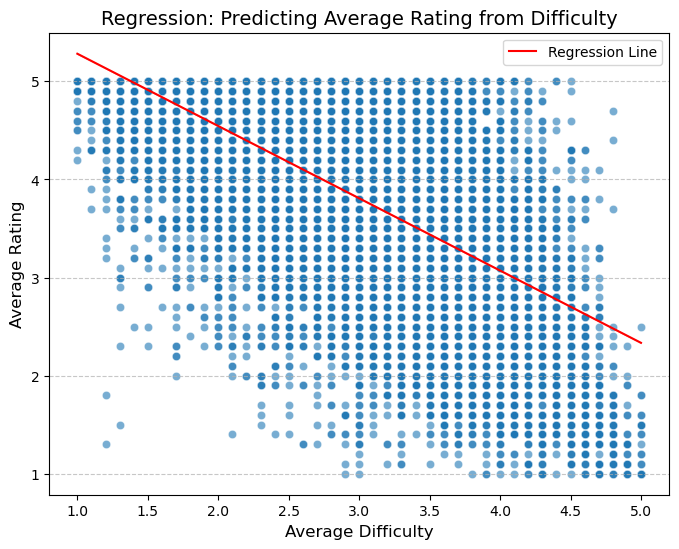

In [299]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="avg_difficulty", y="avg_rating", data=difficulty_model_data, alpha=0.6)
sns.lineplot(x=X_test["avg_difficulty"], y=y_pred, color="red", label="Regression Line")
plt.title("Regression: Predicting Average Rating from Difficulty", fontsize=14)
plt.xlabel("Average Difficulty", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()

plt.savefig("regression_avg_rating_vs_difficulty.png")
plt.show()

### Predicting Teaching Ratings Using Multiple Factors

In [302]:
multi_factor_model_data = info.dropna()

In [308]:
X = multi_factor_model_data[["avg_difficulty", "num_ratings", "pepper", "takeagain", "num_ratings_online", "male", "female"]]
y = multi_factor_model_data["avg_rating"]

In [314]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [316]:
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
vif = pd.DataFrame()
vif["feature"] = X_scaled_df.columns
vif["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif)

              feature       VIF
0      avg_difficulty  1.376946
1         num_ratings  1.023925
2              pepper  1.259908
3           takeagain  1.615662
4  num_ratings_online  1.014651
5                male  1.383130
6              female  1.384715


In [318]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=16056132)

In [320]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [322]:
y_pred = model.predict(X_test)

In [324]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [326]:
print(f"Multiple Regression Model - R²: {r2}, RMSE: {rmse}")

Multiple Regression Model - R²: 0.8000136924847091, RMSE: 0.3734390701669639


In [330]:
betas = pd.DataFrame({"Feature": X.columns, "Beta": model.coef_})
print(betas)

              Feature      Beta
0      avg_difficulty -0.147936
1         num_ratings -0.001983
2              pepper  0.105325
3           takeagain  0.615144
4  num_ratings_online -0.000328
5                male  0.029664
6              female  0.013915


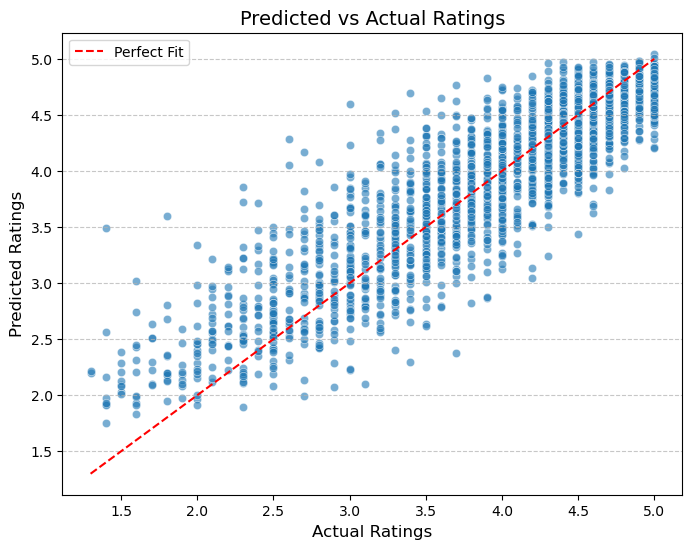

In [328]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.title("Predicted vs Actual Ratings", fontsize=14)
plt.xlabel("Actual Ratings", fontsize=12)
plt.ylabel("Predicted Ratings", fontsize=12)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("predicted_vs_actual_ratings.png")
plt.show()

### Can Average Rating Predict Whether a Professor is Considered "Hot"?

In [335]:
q9_data = info.dropna(subset=["avg_rating", "pepper"])

In [337]:
X = q9_data[["avg_rating"]]
y = q9_data["pepper"]

In [339]:
y.value_counts()

pepper
0.0    11561
1.0     9016
Name: count, dtype: int64

In [343]:
smote = SMOTE(random_state = 16056132)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(pd.Series(y_resampled).value_counts())

pepper
1.0    11561
0.0    11561
Name: count, dtype: int64


In [345]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=16056132)

In [349]:
model = LogisticRegression(random_state = 16056132)
model.fit(X_train, y_train)

LogisticRegression(random_state=16056132)

In [351]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [355]:
auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"AU(RO)C: {auc}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

AU(RO)C: 0.7874726551703374
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.65      0.70      2327
         1.0       0.69      0.80      0.74      2298

    accuracy                           0.72      4625
   macro avg       0.73      0.72      0.72      4625
weighted avg       0.73      0.72      0.72      4625

Confusion Matrix:
[[1513  814]
 [ 462 1836]]


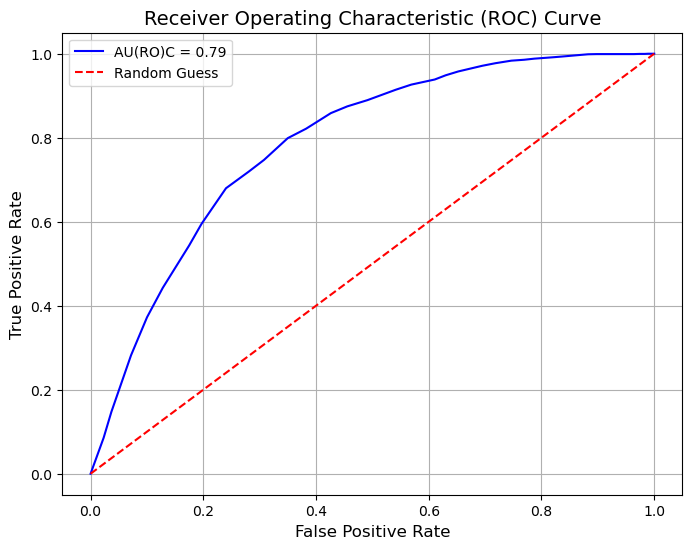

In [357]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"AU(RO)C = {auc:.2f}")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend()
plt.grid()
plt.savefig("roc_curve_pepper_prediction.png")
plt.show()

### Gender Bias in Student Ratings

In [360]:
all_factors_model_data = info.dropna(subset = ["avg_difficulty", "num_ratings", "takeagain", "num_ratings_online", "male", "female", "avg_rating", "pepper"])

# Define predictors (X) and target (y)
X = all_factors_model_data[["avg_difficulty", "num_ratings", "takeagain", "num_ratings_online", "male", "female", "avg_rating"]]
y = all_factors_model_data["pepper"]

In [362]:
print("Class Distribution Before Balancing:")
print(y.value_counts())

smote = SMOTE(random_state = 16056132)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class Distribution After Balancing:")
print(pd.Series(y_resampled).value_counts())

Class Distribution Before Balancing:
pepper
0.0    6353
1.0    5585
Name: count, dtype: int64
Class Distribution After Balancing:
pepper
0.0    6353
1.0    6353
Name: count, dtype: int64


In [366]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=16056132)

# Step 4: Train the logistic regression model
model = LogisticRegression(random_state=16056132, max_iter = 1000)
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [368]:
auc = roc_auc_score(y_test, y_prob)

# Classification report and confusion matrix
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print metrics
print(f"AU(RO)C: {auc}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

AU(RO)C: 0.7977188665521457
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71      1267
         1.0       0.71      0.78      0.74      1275

    accuracy                           0.73      2542
   macro avg       0.73      0.73      0.73      2542
weighted avg       0.73      0.73      0.73      2542

Confusion Matrix:
[[855 412]
 [278 997]]


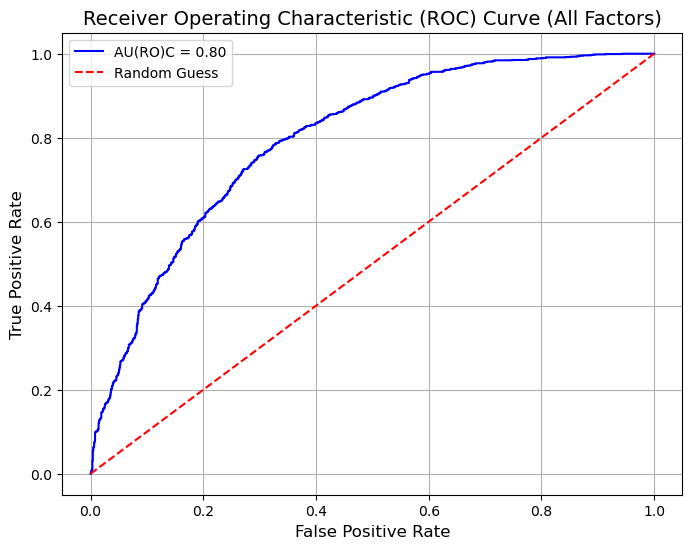

In [370]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"AU(RO)C = {auc:.2f}")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve (All Factors)", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend()
plt.grid()
plt.savefig("roc_curve_pepper_prediction_all_factors.png")
plt.show()